# **Tasks needed to be done**
1. Bandpass fiter
2. Heart rate = calulate two peak (local maxima) and average
3. Respiratory rate = calulate two peak (local maxima) and average
4. HRV Metrics: RMSSD, SSRR, pNN50
5. PPT:  Average RR interval
6. Calculate Pulse Transit Time (PTT) as time differences between peaks
7. Compare

# **Resting Mode:**
**Heart Rate (bpm) for Resting:** 87.37\
**Heart Rate (bpm) for Resting after removing unnecessary peak:**  91.53\
**Respiratory Rate (breaths per minute) for Resting:** 16.32\
**HRV Metrics:**\
  **RMSSD for resting:** 0.12 seconds\
  **SDRR for resting:** 0.10 seconds\
  **pNN50 for resting:** 16.85%

# **Sport Mode**
**Heart Rate (bpm) for Sport:** 102.72\
**Respiratory Rate (breaths per minute) for Sport:** 16.96\
**RMSSD for Sport:** 0.02 seconds\
**SDRR for Sport**: 0.04 seconds\
**pNN50 for Sport:** 1.10%\



**Dataset load**

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks, detrend

# file_path = file_path = 'Group7_PPG.mat'
file_path = 'Group7_PPGsport.mat'
with h5py.File(file_path, 'r') as mat_file:
     y_data = mat_file['y'][()]

# **For Resting**

Column 1


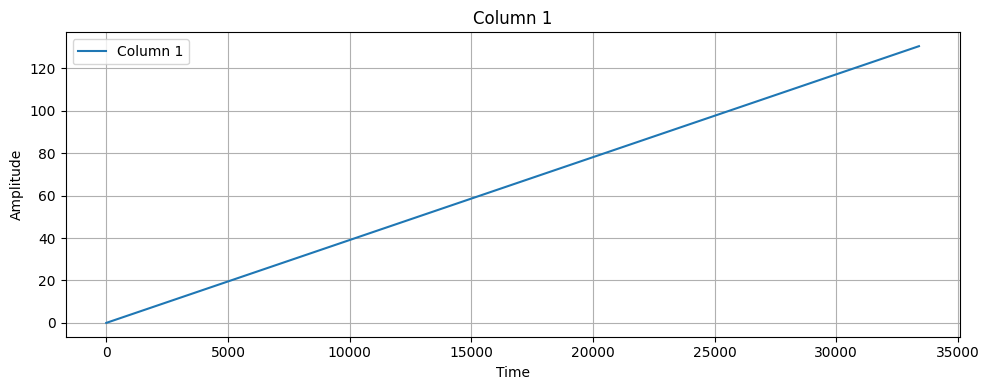

Column 2


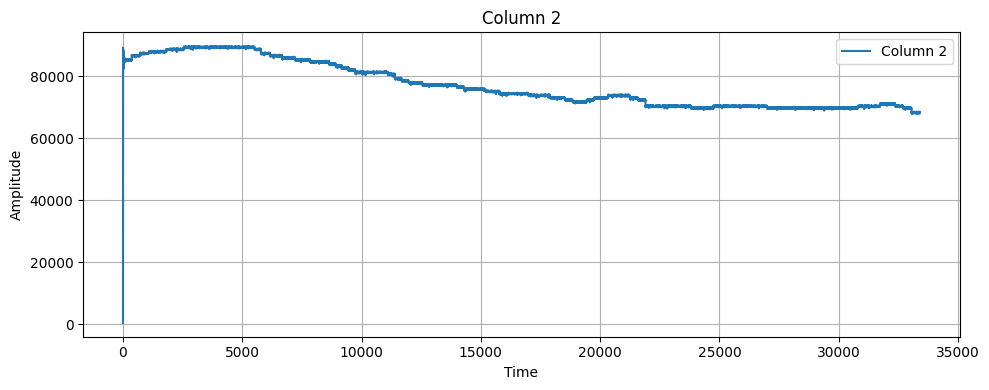

Column 3


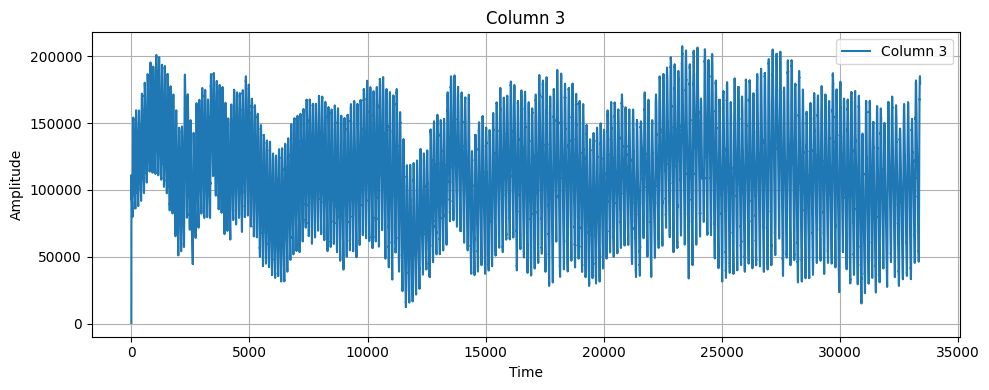

Column 4


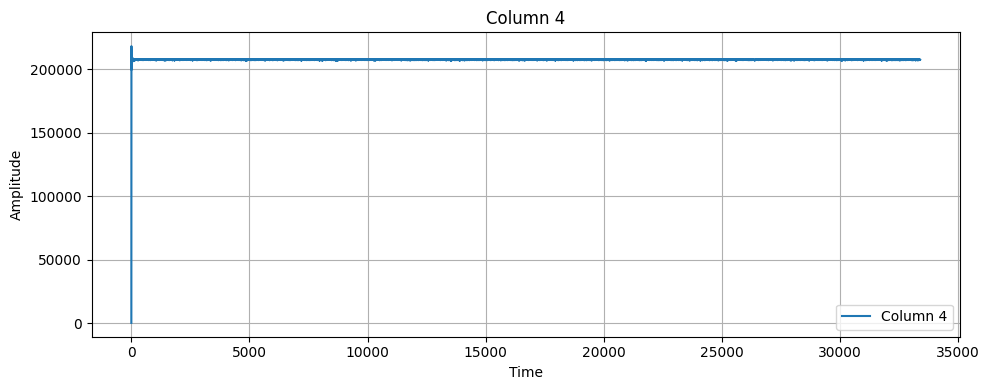

Column 5


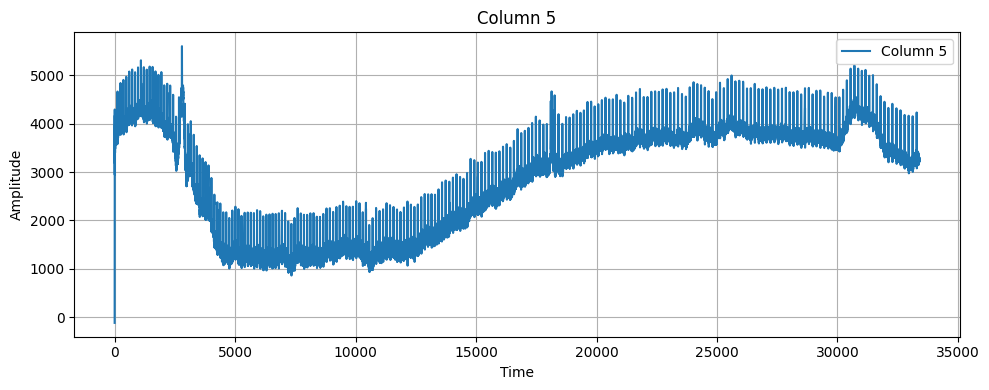

Column 6


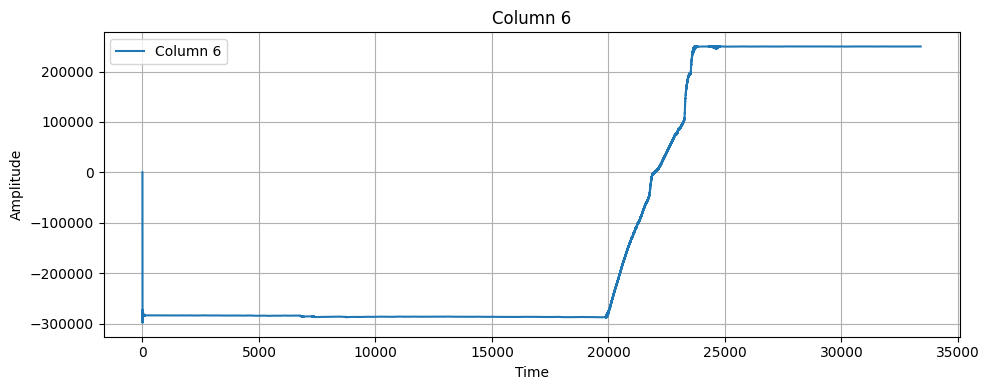

In [ ]:
# Extract all 6 columns from the dataset
columns = [y_data[:, i] for i in range(6)]
column_labels = ["Column 1", "Column 2", "Column 3", "Column 4", "Column 5", "Column 6"]

def plot_column(index):
    plt.figure(figsize=(10, 4))
    plt.plot(columns[index], label=column_labels[index])
    plt.title(column_labels[index])
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

for i in range(6):
    print(f"{column_labels[i]}")
    plot_column(i)

In [ ]:
time = y_data[:, 0] #time, 1 in Matlab
ppg_signal = y_data[:, 2] #ppg, 3 in Matlab
respiratory_signal = y_data[:, 5] #respiratory, 6 in matlab

**Bandpass filter implementation** \
**Link:** https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter bold text \
b and a: The filter coefficients from the butter function.\
[low, high]: The normalized cutoff frequencies.\
filtfilt eliminates this phase shift by:\
Filtering the signal forward (left to right).\
Reversing the signal and filtering it backward (right to left).\

In [ ]:
def bandpass_filter(signal, low_cutoff, high_cutoff, sampling_rate):
    nyquist = 0.5 * sampling_rate
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = butter(2, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

**Filtered PPG**\
Low Cutoff (0.1 Hz) = 30/60\
high_cutoff (10 Hz) = 240/60 \


**Filtered Respiratory**\ (based on number of breathing rate per min: high and low)
Low Cutoff (0.2 Hz) = 12/60\
high_cutoff (0.5 Hz) = 30/60 \

In [ ]:
# Apply bandpass filter
sampling_rate = 256  # 256 Hz
# for ppg
filtered_ppg = bandpass_filter(ppg_signal, low_cutoff=0.1, high_cutoff=5, sampling_rate=sampling_rate)

# for Respiratory
normalized_resp = (respiratory_signal - np.min(respiratory_signal)) / (np.max(respiratory_signal) - np.min(respiratory_signal))
filtered_resp = bandpass_filter(normalized_resp, low_cutoff=0.1, high_cutoff=0.5, sampling_rate=sampling_rate)

# Scale the filtered signal to match raw signal amplitude
scaled_filtered_resp = filtered_resp * (np.max(respiratory_signal) / np.max(filtered_resp))

# Reintroduce the baseline to align the filtered signal with the raw signal
re_aligned_filtered_resp = scaled_filtered_resp + np.mean(respiratory_signal)

#filtered_resp = bandpass_filter(respiratory_signal, low_cutoff=0.2, high_cutoff=0.5, sampling_rate=sampling_rate)


Indices of detected peaks in the PPG signal.\
256/4 between consecutive peaks\
differences between the indices of consecutive detected peaks\
**Link:** https://iu.pressbooks.pub/humanphys/chapter/minute-and-alveolar-ventilation/?utm_source=chatgpt.com \
**Minute Ventilation** = Tidal Volume × Respiratory Rate

In [ ]:
ppg_peaks_locs, _ = find_peaks(filtered_ppg, distance=sampling_rate / 4)

rr_intervals = np.diff(ppg_peaks_locs) / sampling_rate
rr_intervals = rr_intervals[(rr_intervals > 0.5) & (rr_intervals < 2.0)]

heart_rate = np.mean(60 / rr_intervals)

resp_peaks_locs, _ = find_peaks(filtered_resp, distance=sampling_rate / 4)
respiratory_rate = 60 / np.mean(np.diff(resp_peaks_locs) / sampling_rate)


# _, ppg_peak_locs = find_peaks(filtered_ppg, distance=sampling_rate / 4)
# rr_intervals = np.diff(ppg_peak_locs) / sampling_rate
# heart_rate = 60 / rr_intervals
# heart_rate_avg = np.mean(heart_rate)

# _, resp_peak_locs = find_peaks(filtered_resp, distance=sampling_rate / 4)
# respiratory_rate = 60 / np.mean(np.diff(resp_peak_locs) / sampling_rate)

In [ ]:
heart_rate #resting

87.3706115508891

In [ ]:
respiratory_rate #resting

16.316558225999202

In [ ]:
#sport
heart_rate

102.72290594633583

In [ ]:
respiratory_rate #sport

16.957920635922022

**RR Intervals:** Time differences between successive PPG peaks (in seconds).\
**RMSSD:** Root Mean Square of Successive Differences, a measure of short-term variability.\
**SDRR:** Standard Deviation of RR Intervals, a measure of overall variability.\
**pNN50:** Percentage of RR interval differences > 50 ms.

**Link:** https://pmc.ncbi.nlm.nih.gov/articles/PMC5624990/

In [ ]:
# HRV calculations: RMSSD, SDNN, pNN50
# rr_intervals = np.diff(ppg_peaks) / sampling_rate
rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
sdrr = np.std(rr_intervals)
pnn50 = np.sum(np.abs(np.diff(rr_intervals)) > 0.05) / len(rr_intervals) * 100

**Pulse Transit Time (PTT): Average RR interval (simplified here).**

In [ ]:
# Calculate Pulse Transit Time (PTT)
# ptt = np.mean(rr_intervals)  # Simplified for illustrative purposes

# **Resting Mode**

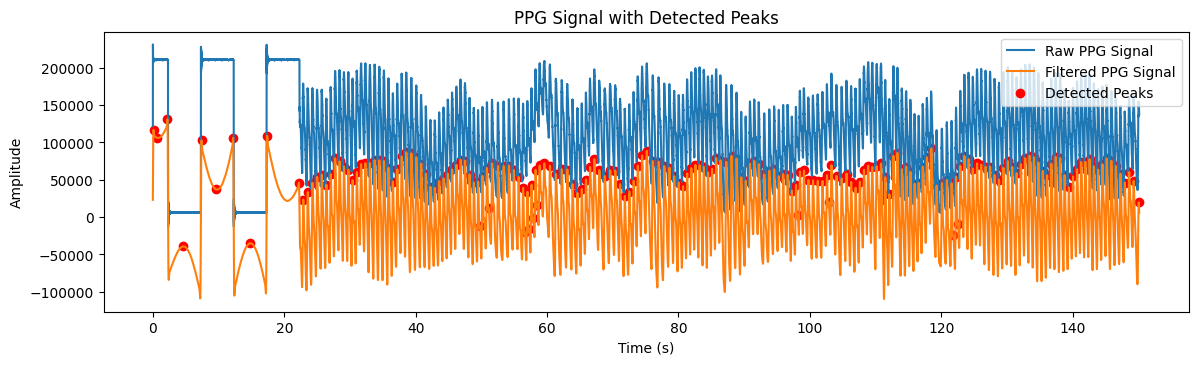

In [ ]:
# Plot PPG Signal
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(time, ppg_signal, label='Raw PPG Signal')
plt.plot(time, filtered_ppg, label='Filtered PPG Signal')
plt.scatter(time[ppg_peaks_locs], filtered_ppg[ppg_peaks_locs], color='red', label='Detected Peaks')
plt.title('PPG Signal with Detected Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

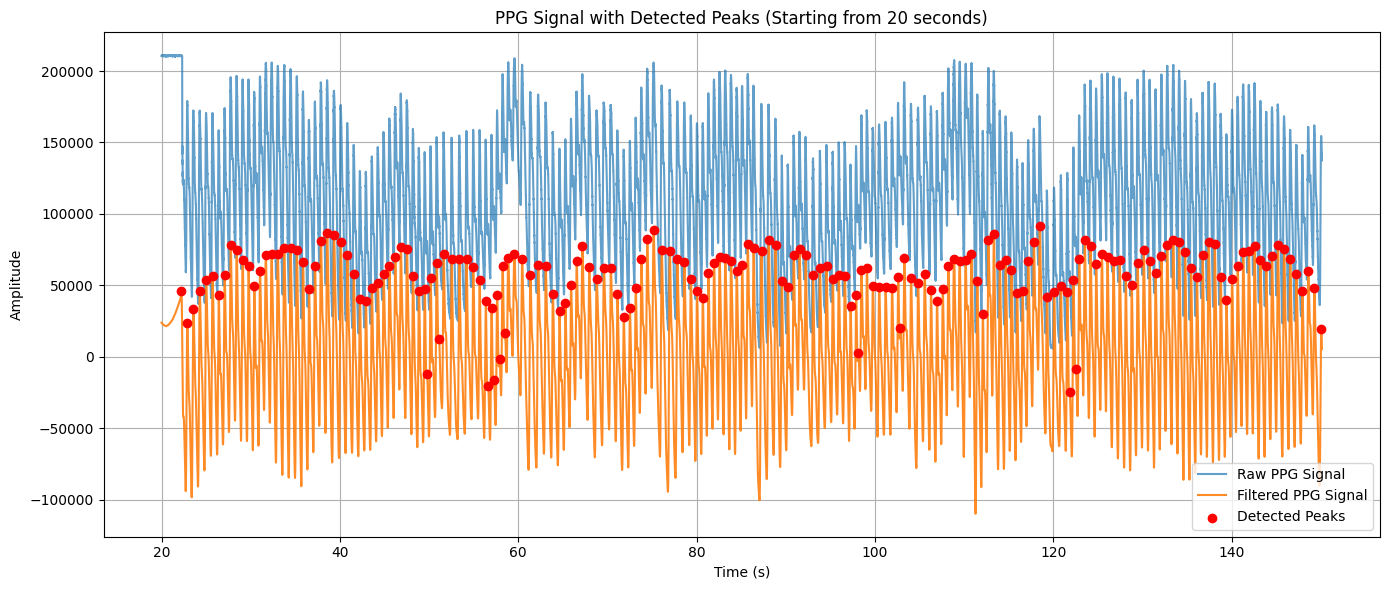

Heart Rate (bpm) starting from 20 seconds: 91.53


In [ ]:
# Filter PPG data to start from 20 seconds
start_time = 20  # seconds
start_index = np.where(time >= start_time)[0][0]


time_subset = time[start_index:]
ppg_signal_subset = ppg_signal[start_index:]
filtered_ppg_subset = filtered_ppg[start_index:]

ppg_peaks_subset, _ = find_peaks(filtered_ppg_subset, distance=sampling_rate / 4)
heart_rate_subset = 60 / np.mean(np.diff(ppg_peaks_subset) / sampling_rate)


# Plot PPG Signal starting from 20 seconds
plt.figure(figsize=(14, 6))
plt.plot(time_subset, ppg_signal_subset, label='Raw PPG Signal', alpha=0.7)
plt.plot(time_subset, filtered_ppg_subset, label='Filtered PPG Signal', alpha=0.9)
plt.scatter(time_subset[ppg_peaks_subset], filtered_ppg_subset[ppg_peaks_subset], color='red', label='Detected Peaks', zorder=5)
plt.title('PPG Signal with Detected Peaks (Starting from 20 seconds)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(f"Heart Rate (bpm) starting from 20 seconds: {heart_rate_subset:.2f}")


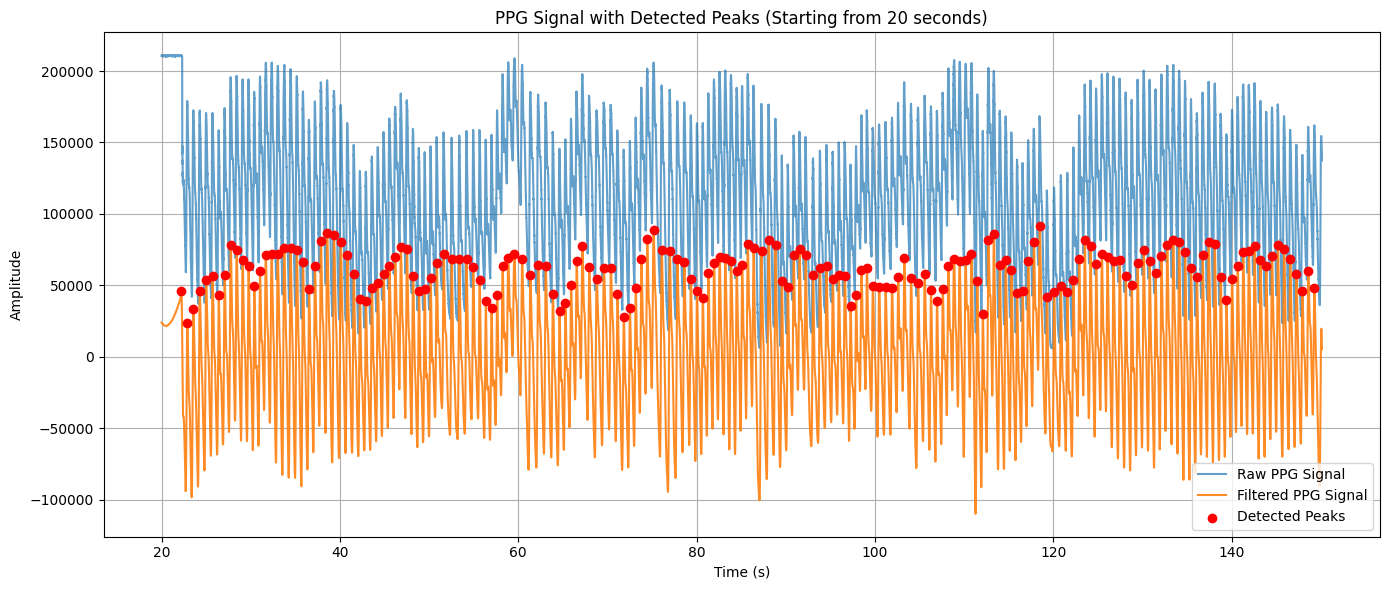

Heart Rate (bpm) starting from 20 seconds: 91.53


In [ ]:
# Filter PPG data to start from 20 seconds
start_time = 20  # seconds
start_index = np.where(time >= start_time)[0][0]


time_subset = time[start_index:]
ppg_signal_subset = ppg_signal[start_index:]
filtered_ppg_subset = filtered_ppg[start_index:]

ppg_peaks_subset, _ = find_peaks(filtered_ppg_subset, distance=sampling_rate / 4)
heart_rate_subset = 60 / np.mean(np.diff(ppg_peaks_subset) / sampling_rate)

ppg_peaks_subset, _ = find_peaks(
    filtered_ppg_subset,
    distance=sampling_rate / 4,
    prominence=4000,  # Adjust based on signal characteristics
    height=20000        # Optional, set a minimum amplitude threshold
)


# Plot PPG Signal starting from 20 seconds
plt.figure(figsize=(14, 6))
plt.plot(time_subset, ppg_signal_subset, label='Raw PPG Signal', alpha=0.7)
plt.plot(time_subset, filtered_ppg_subset, label='Filtered PPG Signal', alpha=0.9)
plt.scatter(time_subset[ppg_peaks_subset], filtered_ppg_subset[ppg_peaks_subset], color='red', label='Detected Peaks', zorder=5)
plt.title('PPG Signal with Detected Peaks (Starting from 20 seconds)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(f"Heart Rate (bpm) starting from 20 seconds: {heart_rate_subset:.2f}")


In [ ]:
heart_rate_subset

91.52915291529153

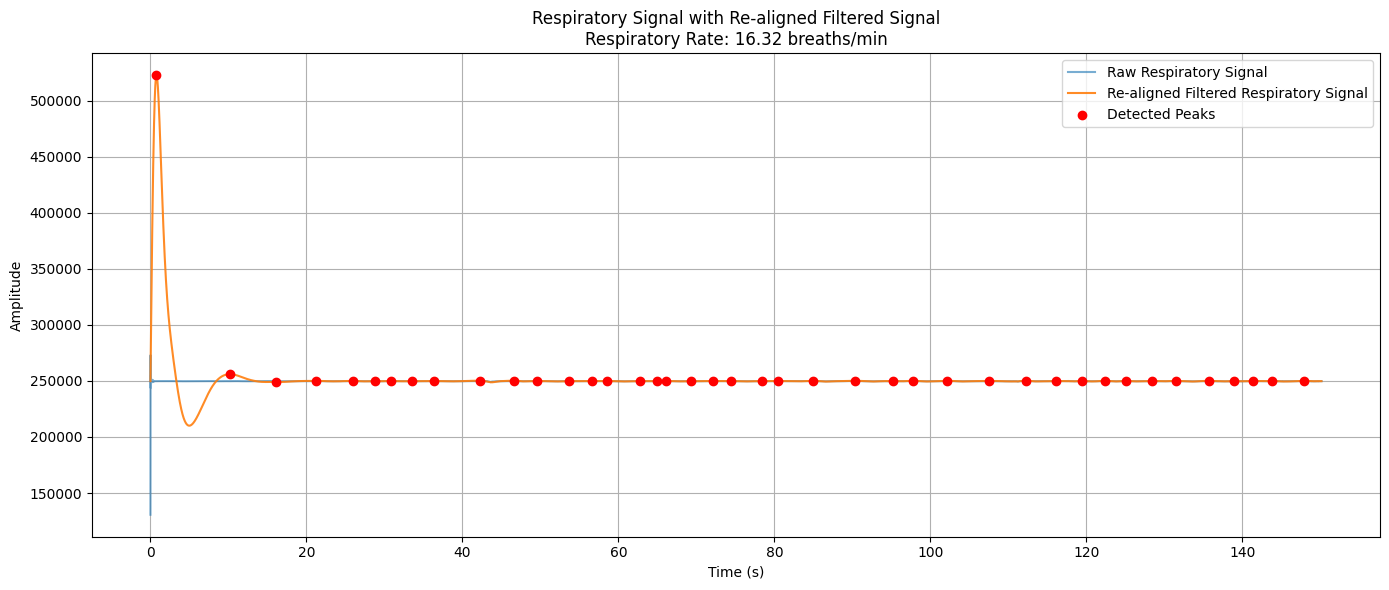

In [ ]:
# Plot the respiratory signals
plt.figure(figsize=(14, 6))
plt.plot(time, respiratory_signal, label='Raw Respiratory Signal', alpha=0.6)
plt.plot(time, re_aligned_filtered_resp, label='Re-aligned Filtered Respiratory Signal', alpha=0.9)
plt.scatter(time[resp_peaks_locs], re_aligned_filtered_resp[resp_peaks_locs], color='red', label='Detected Peaks', zorder=5)


# Add title and labels
plt.title(f'Respiratory Signal with Re-aligned Filtered Signal\nRespiratory Rate: {respiratory_rate:.2f} breaths/min')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


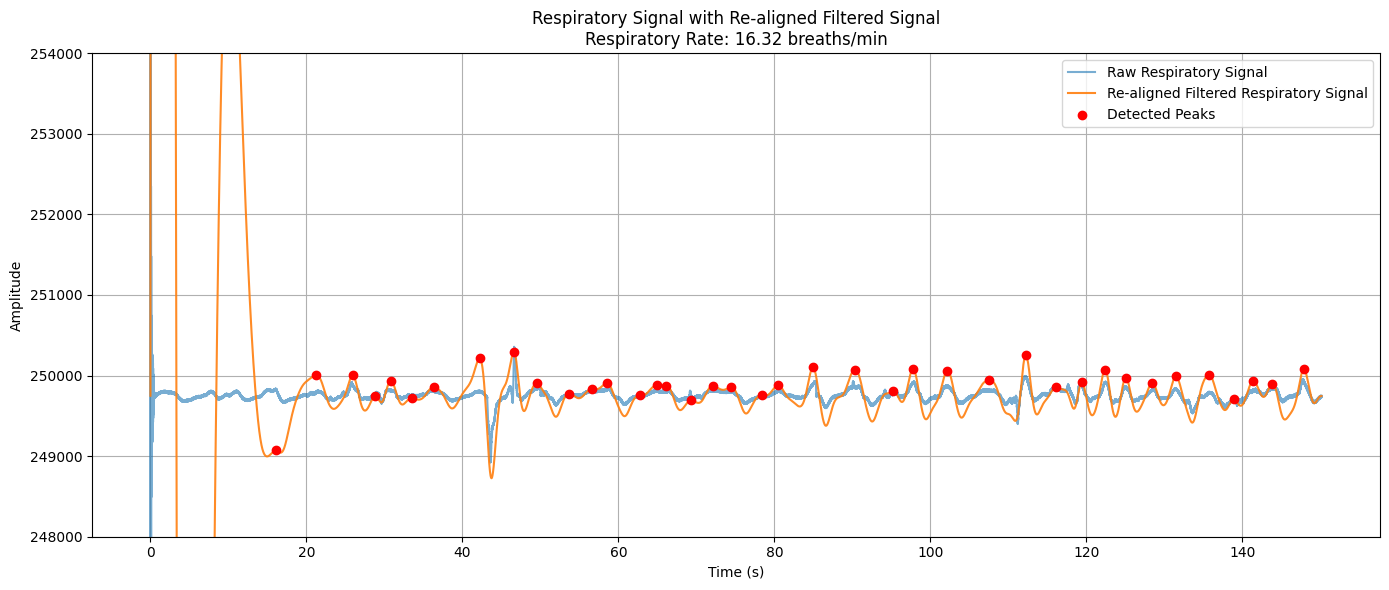

In [ ]:
# Plot the respiratory signals
plt.figure(figsize=(14, 6))
plt.plot(time, respiratory_signal, label='Raw Respiratory Signal', alpha=0.6)
plt.plot(time, re_aligned_filtered_resp, label='Re-aligned Filtered Respiratory Signal', alpha=0.9)
plt.scatter(time[resp_peaks_locs], re_aligned_filtered_resp[resp_peaks_locs], color='red', label='Detected Peaks', zorder=5)


# Adjust y-axis limits for better visualization
plt.ylim(248000, 254000)

# Add title and labels
plt.title(f'Respiratory Signal with Re-aligned Filtered Signal\nRespiratory Rate: {respiratory_rate:.2f} breaths/min')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
# Print results
Resting_Heart_rate = f"Heart Rate (bpm) for Resting: {heart_rate:.2f}"
Resting_Heart_rate2 = f"Heart Rate (bpm) for Resting after removing unnecessary peak: {heart_rate_subset:.2f}"
Resting_Respiratory_Rate = f"Respiratory Rate (breaths per minute) for Resting: {respiratory_rate:.2f}"
Resting_RMSSD = f"  RMSSD for resting: {rmssd:.2f} seconds"
Resting_SDRR = f"  SDNN for resting: {sdrr:.2f} seconds"
Resting_pNN50 = f"  pNN50 for resting: {pnn50:.2f}%"
#Resting_PPT = f"Pulse Transit Time (PTT) for resting: {ptt:.2f} seconds"
print(Resting_Heart_rate)
print(Resting_Heart_rate2)
print(Resting_Respiratory_Rate)
print(f"HRV Metrics:")
print(Resting_RMSSD)
print(Resting_SDRR)
print(Resting_pNN50 )
#print(Resting_PPT)

Heart Rate (bpm) for Resting: 87.37
Heart Rate (bpm) for Resting after removing unnecessary peak: 91.53
Respiratory Rate (breaths per minute) for Resting: 16.32
HRV Metrics:
  RMSSD for resting: 0.12 seconds
  SDNN for resting: 0.10 seconds
  pNN50 for resting: 16.85%


In [ ]:
"""
# Calculate Pulse Transit Time (PTT) as time differences between peaks
ptt_times = time[ppg_peaks[1:]]  # Time corresponding to each RR interval
ptt_values = np.diff(ppg_peaks) / sampling_rate  # Convert indices to time differences

# Plot the PTT graph
plt.figure(figsize=(10, 5))
plt.plot(ptt_times, ptt_values, marker='o', linestyle='-', label='Pulse Transit Time (PTT)')
plt.title('Pulse Transit Time (PTT) over Time')
plt.xlabel('Time (s)')
plt.ylabel('PTT (seconds)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
"""

# **Sport Mode**

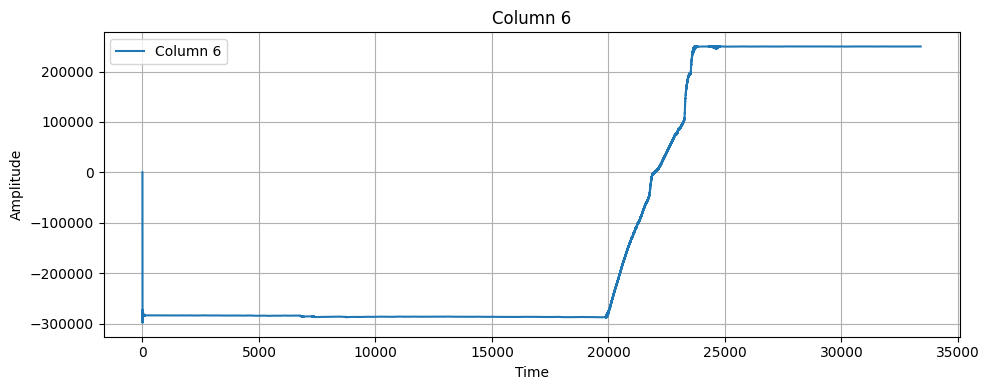

In [ ]:
import matplotlib.pyplot as plt

# Assuming `y_data` is your dataset
columns = [y_data[:, i] for i in range(6)]
column_labels = ["Column 1", "Column 2", "Column 3", "Column 4", "Column 5", "Column 6"]

# Plot only Column 6 (index 5)
plt.figure(figsize=(10, 4))
plt.plot(columns[5], label=column_labels[5])  # Access the 6th column (index 5)
plt.title(column_labels[5])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


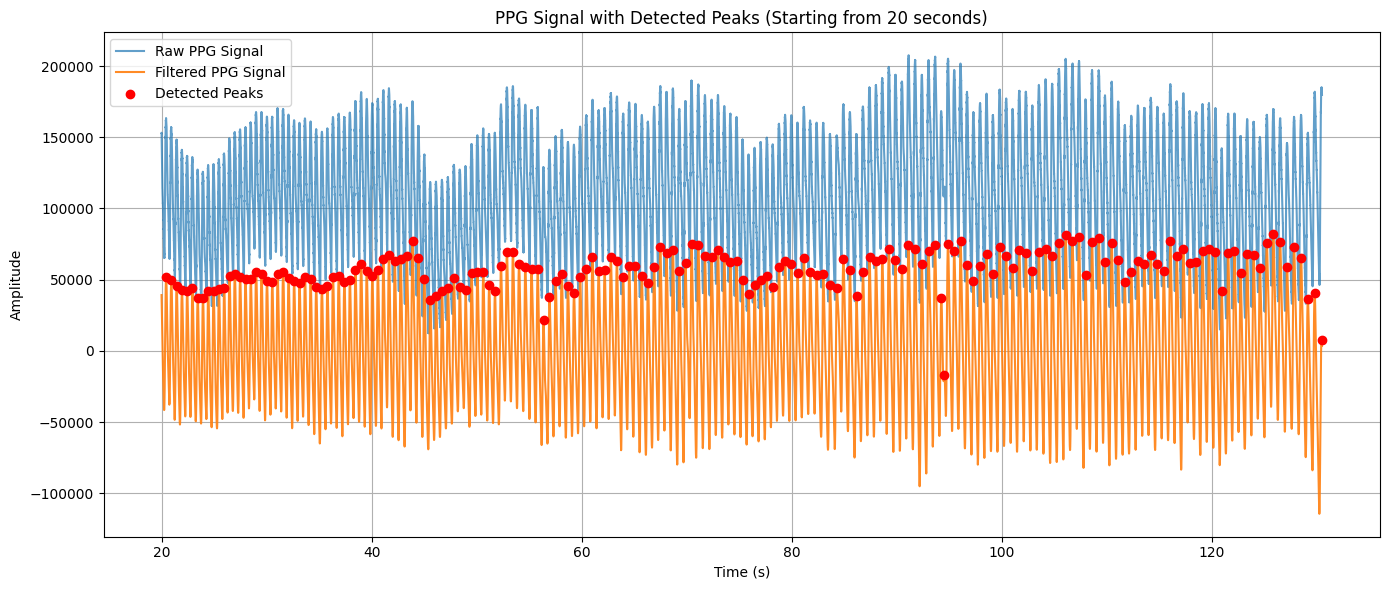

Heart Rate (bpm) starting from 20 seconds: 103.10


In [ ]:
# Filter PPG data to start from 20 seconds
start_time = 20  # seconds
start_index = np.where(time >= start_time)[0][0]


time_subset = time[start_index:]
ppg_signal_subset = ppg_signal[start_index:]
filtered_ppg_subset = filtered_ppg[start_index:]

ppg_peaks_subset, _ = find_peaks(filtered_ppg_subset, distance=sampling_rate / 4)
heart_rate_subset = 60 / np.mean(np.diff(ppg_peaks_subset) / sampling_rate)


# Plot PPG Signal starting from 20 seconds
plt.figure(figsize=(14, 6))
plt.plot(time_subset, ppg_signal_subset, label='Raw PPG Signal', alpha=0.7)
plt.plot(time_subset, filtered_ppg_subset, label='Filtered PPG Signal', alpha=0.9)
plt.scatter(time_subset[ppg_peaks_subset], filtered_ppg_subset[ppg_peaks_subset], color='red', label='Detected Peaks', zorder=5)
plt.title('PPG Signal with Detected Peaks (Starting from 20 seconds)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print the recalculated heart rate
print(f"Heart Rate (bpm) starting from 20 seconds: {heart_rate_subset:.2f}")


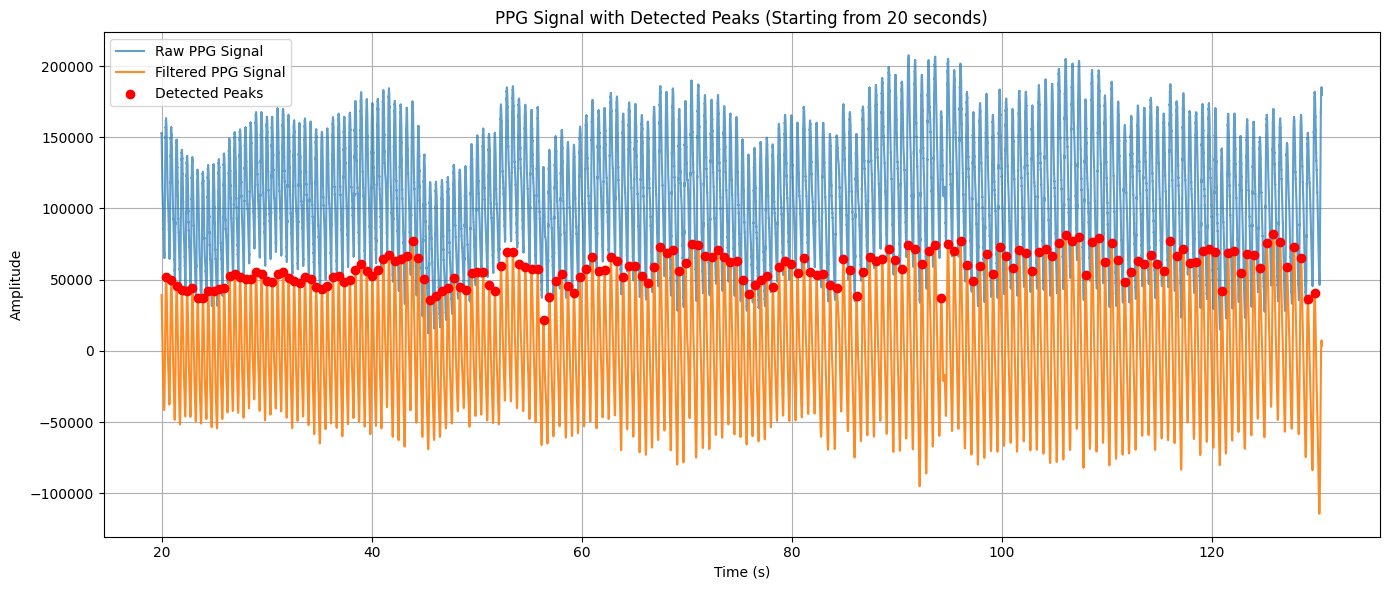

Heart Rate (bpm) starting from 20 seconds: 103.10


In [ ]:
# Filter PPG data to start from 20 seconds
start_time = 20  # seconds
start_index = np.where(time >= start_time)[0][0]


time_subset = time[start_index:]
ppg_signal_subset = ppg_signal[start_index:]
filtered_ppg_subset = filtered_ppg[start_index:]

ppg_peaks_subset, _ = find_peaks(filtered_ppg_subset, distance=sampling_rate / 4)
heart_rate_subset = 60 / np.mean(np.diff(ppg_peaks_subset) / sampling_rate)

ppg_peaks_subset, _ = find_peaks(
    filtered_ppg_subset,
    distance=sampling_rate / 4,
    prominence=2000,  # Adjust based on signal characteristics
    height=20000        # Optional, set a minimum amplitude threshold
)


# Plot PPG Signal starting from 20 seconds
plt.figure(figsize=(14, 6))
plt.plot(time_subset, ppg_signal_subset, label='Raw PPG Signal', alpha=0.7)
plt.plot(time_subset, filtered_ppg_subset, label='Filtered PPG Signal', alpha=0.9)
plt.scatter(time_subset[ppg_peaks_subset], filtered_ppg_subset[ppg_peaks_subset], color='red', label='Detected Peaks', zorder=5)
plt.title('PPG Signal with Detected Peaks (Starting from 20 seconds)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print the recalculated heart rate
print(f"Heart Rate (bpm) starting from 20 seconds: {heart_rate_subset:.2f}")


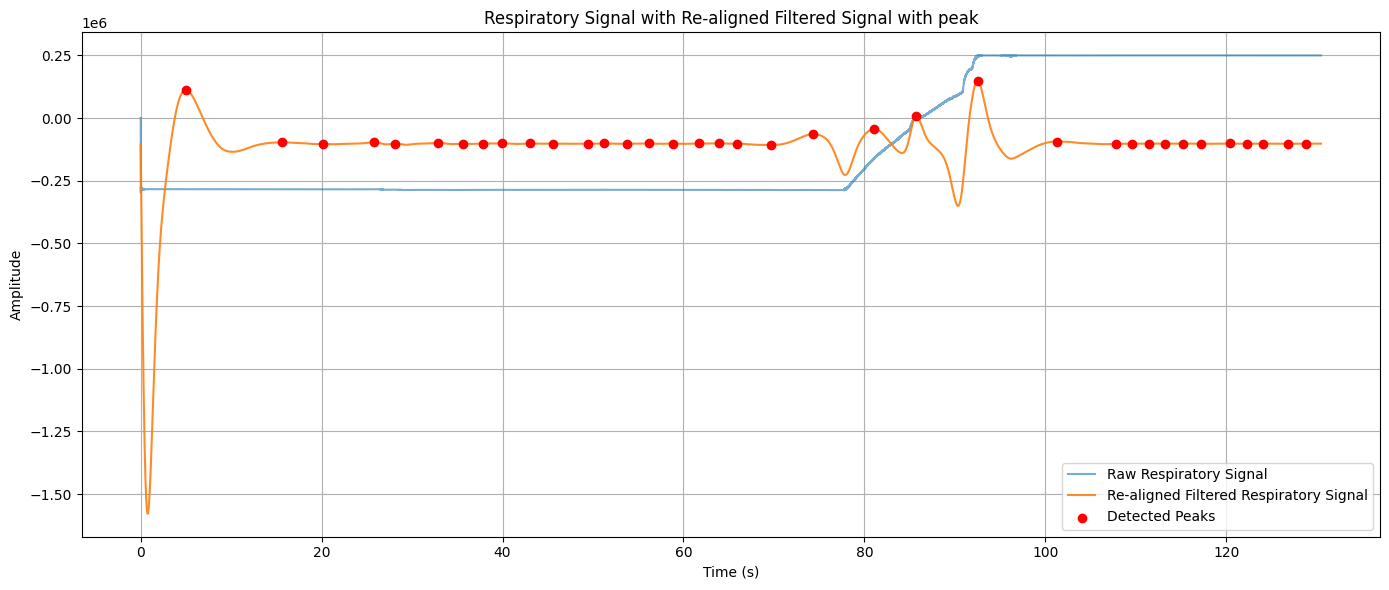

In [ ]:
# Plot the respiratory signals
plt.figure(figsize=(14, 6))
plt.plot(time, respiratory_signal, label='Raw Respiratory Signal', alpha=0.6)
plt.plot(time, re_aligned_filtered_resp, label='Re-aligned Filtered Respiratory Signal', alpha=0.9)
plt.scatter(time[resp_peaks_locs], re_aligned_filtered_resp[resp_peaks_locs], color='red', label='Detected Peaks', zorder=5)


# Add title and labels
plt.title(f'Respiratory Signal with Re-aligned Filtered Signal with peak')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
# Print results
Sport_Heart_rate = f"Heart Rate (bpm) for Sport: {heart_rate:.2f}"
Sport_Heart_rate2 = f"Heart Rate (bpm) for Sport after removing unnecessary peak: {heart_rate_subset:.2f}"
Sport_Respiratory_Rate = f"Respiratory Rate (breaths per minute) for Sport: {respiratory_rate:.2f}"
Sport_RMSSD = f"  RMSSD for Sport: {rmssd:.2f} seconds"
Sport_SDRR = f"  SDNN for Sport: {sdrr:.2f} seconds"
Sport_pNN50 = f"  pNN50 for Sport: {pnn50:.2f}%"
#Resting_PPT = f"Pulse Transit Time (PTT) for resting: {ptt:.2f} seconds"
print(Sport_Heart_rate)
print(Sport_Heart_rate2)
print(Sport_Respiratory_Rate)
print(f"HRV Metrics:")
print(Sport_RMSSD)
print(Sport_SDRR)
print(Sport_pNN50 )
#print(Resting_PPT)

Heart Rate (bpm) for Sport: 102.72
Heart Rate (bpm) for Sport after removing unnecessary peak: 103.10
Respiratory Rate (breaths per minute) for Sport: 16.96
HRV Metrics:
  RMSSD for Sport: 0.02 seconds
  SDNN for Sport: 0.04 seconds
  pNN50 for Sport: 1.10%


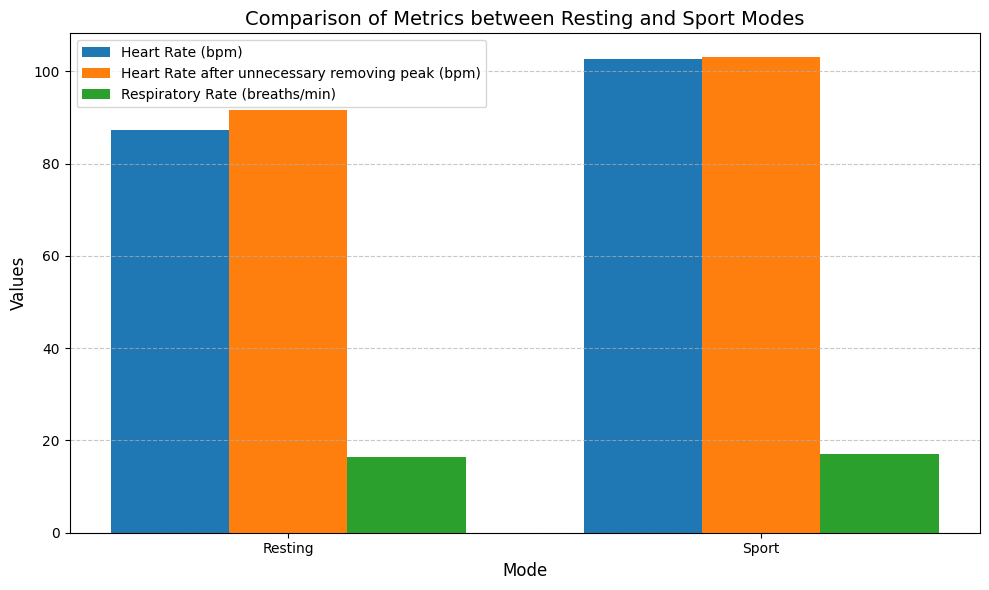

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


modes = ['Resting', 'Sport']

heart_rate = [87.37, 102.72]
heart_rate_no_peak = [91.53, 103.10]
respiratory_rate = [16.32, 16.96]

x = np.arange(len(modes))  # the label locations
bar_width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - bar_width, heart_rate, bar_width, label='Heart Rate (bpm)')
ax.bar(x, heart_rate_no_peak, bar_width, label='Heart Rate after unnecessary removing peak (bpm)')
ax.bar(x + bar_width, respiratory_rate, bar_width, label='Respiratory Rate (breaths/min)')

ax.set_xlabel('Mode', fontsize=12)
ax.set_ylabel('Values', fontsize=12)
ax.set_title('Comparison of Metrics between Resting and Sport Modes', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(modes)
ax.legend()

ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
